In [3]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX

import math

# sys.path.append('/home/cms/Desktop/LLP/cms_lpc_llp/jet_timing_studies/python/lib')
# sys.path.append('/nfshome/christiw/llp/cms_lpc_llp/jet_timing_studies/python/lib')
sys.path.append('/nfshome/christiw/llp/delayed_jet_analyzer/lib/')
# sys.path.append('/nfshome/christiw/llp/cms_lpc_llp/llp_analyzer/python/lib')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list
     
import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

# donotdelete = []
print(sys.version)

3.6.8 (default, Apr 25 2019, 21:02:35) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-36)]


In [4]:
dirs = {}
dirs['prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root'] = '/mnt/hadoop//store/group/phys_exotica/jmao/aodsim/RunIISummer16/delphes_output/'
dirs['pl1000_n3n2-n1-hbb-hbb-0827-m200-evt10000.root'] = '/mnt/hadoop//store/group/phys_exotica/jmao/aodsim/RunIISummer16/delphes_output/'
dirs['prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root'] = '/mnt/hadoop//store/group/phys_exotica/jmao/aodsim/RunIISummer16/delphes_output/'
dirs['pl1000_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root'] = '/mnt/hadoop//store/group/phys_exotica/jmao/aodsim/RunIISummer16/delphes_output/'
dirs['2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root'] = '/mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/SusyEwkHgg/Signal2016/TChiHH/'
dirs['2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root'] = '/mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/SusyEwkHgg/Signal2016/TChiWH/'

# directory = '/mnt/hadoop//store/group/phys_exotica/jmao/aodsim/RunIISummer16/delphes_output/'
# directory1 = '/mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/SusyEwkHgg/Signal2016/TChiHH/'
#2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root
# directory2 = '/mnt/hadoop/store/group/phys_susy/razor/Run2Analysis/SusyEwkHgg/Signal2016/TChiWH/'
#2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root
out_dir = '/nfshome/jmao/cms-llp/plots/20190905/'

fname = {
    'prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root',
    'pl1000_n3n2-n1-hbb-hbb-0827-m200-evt10000.root',
    'prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root',
    'pl1000_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root',
    '2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root',
    '2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root',
        }

texs = {}

texs['prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root'] = 'prompt, H(bb)H(bb)'
texs['pl1000_n3n2-n1-hbb-hbb-0827-m200-evt10000.root'] = 'ctau = 1 m, H(bb)H(bb)'
texs['prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root'] = 'prompt, W(lv)H(bb)'
texs['pl1000_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root'] = 'ctau = 1 m, W(lv)H(bb)'
texs['2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root'] = 'cms, H(gg)H(gg)'
texs['2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root'] = 'cms, W(lv)H(gg)'

cols = {}

cols['prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root'] = 2
cols['pl1000_n3n2-n1-hbb-hbb-0827-m200-evt10000.root'] = 3
cols['prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root'] = 4
cols['pl1000_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root'] = 6
cols['2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root'] = 207
cols['2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root'] = 51

tree = OrderedDict()

f_dir = ''
for file in fname:
#     print(directory+file)
#     if 'evt' in fname:
#         f_dir = directory
    root_dir = uproot.open(dirs[file]+file) 
    if 'evt' in file:
        tree[file] = root_dir['Delphes']
    else:
        tree[file] = root_dir['HggRazorLeptons']
#     elif 'TChiHH' in fname:
#         f_dir = directory1
#         root_dir = uproot.open(directory1+file) 
#         tree[file] = root_dir['HggRazorLeptons']
#     elif 'TChiWH' in fname:
#         f_dir = directory2
#         tree[file] = root_dir['HggRazorLeptons']
    print ('Open ready')
    print(texs[file])
    print ('Tree ready') 
    print(tree[file], tree)

Open ready
prompt, W(lv)H(bb)
Tree ready
<TTree b'Delphes' at 0x7fd38b700550> OrderedDict([('prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root', <TTree b'Delphes' at 0x7fd38b700550>)])
Open ready
cms, H(gg)H(gg)
Tree ready
<TTree b'HggRazorLeptons' at 0x7fd3331172e8> OrderedDict([('prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root', <TTree b'Delphes' at 0x7fd38b700550>), ('2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root', <TTree b'HggRazorLeptons' at 0x7fd3331172e8>)])
Open ready
cms, W(lv)H(gg)
Tree ready
<TTree b'HggRazorLeptons' at 0x7fd32f2c3160> OrderedDict([('prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root', <TTree b'Delphes' at 0x7fd38b700550>), ('2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root', <TTree b'HggRazorLeptons' at 0x7fd3331172e8>), ('2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root', <TTree b'HggRazorLeptons' at 0x7fd32f2c3160>)])
Open ready
ctau = 1 m, H(bb)H(bb)


# b jet Pt

prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7fd38b700550>
2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7fd3331172e8>
2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7fd32f2c3160>
pl1000_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7fd32d408860>
pl1000_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7fd2ff466320>
prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7fd2d56805c0>


Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190905/b_pt.png has been created


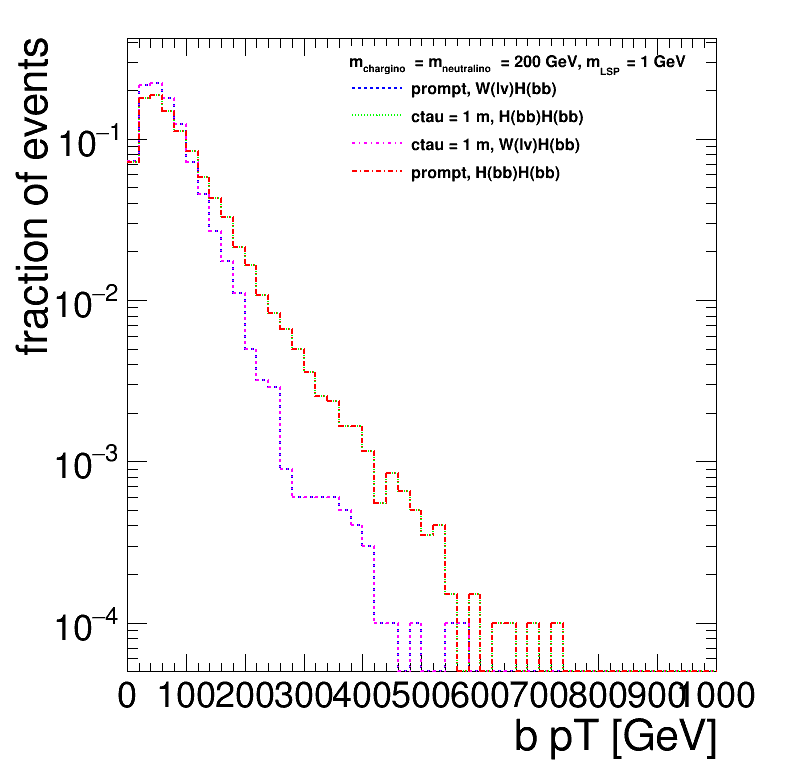

In [5]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0
ht = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    if 'evt' in k:
    
        pid = v['Particle.PID'].array()
        status = v['Particle.Status'].array()
        pt = v['Particle.PT'].array()
    #     bro_pt = v['Particle.PT[Particle.D2[Particle.M1]]'].array()
        met = v['MissingET.MET'].array()


        basic_str = np.logical_and(pid==5, status==23)

        b_pt = pt[basic_str]
    #     b_bro_pt = bro_pt[basic_str]

        b_pt_all = b_pt.flatten()

        ht[k] = create_TH1D( b_pt_all, axis_title=['b pT [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        ht[k].SetLineStyle(i+2)
        ht[k].SetLineColor(cols[k])
        ht[k].SetMarkerColor(cols[k])

        ht[k].DrawNormalized('same')

        leg.AddEntry(ht[k], texs[k])
 
        i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'b_pt.png')

# MET

2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7fbe22199978>
2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7fbe20161cf8>
prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7fbe1c343fd0>
<class 'awkward.array.jagged.JaggedArray'>
pl1000_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7fbdec911be0>
<class 'awkward.array.jagged.JaggedArray'>
pl1000_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7fbdc2b774a8>
<class 'awkward.array.jagged.JaggedArray'>
prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7fbd94ae5128>
<class 'awkward.array.jagged.JaggedArray'>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190905/met.png has been created


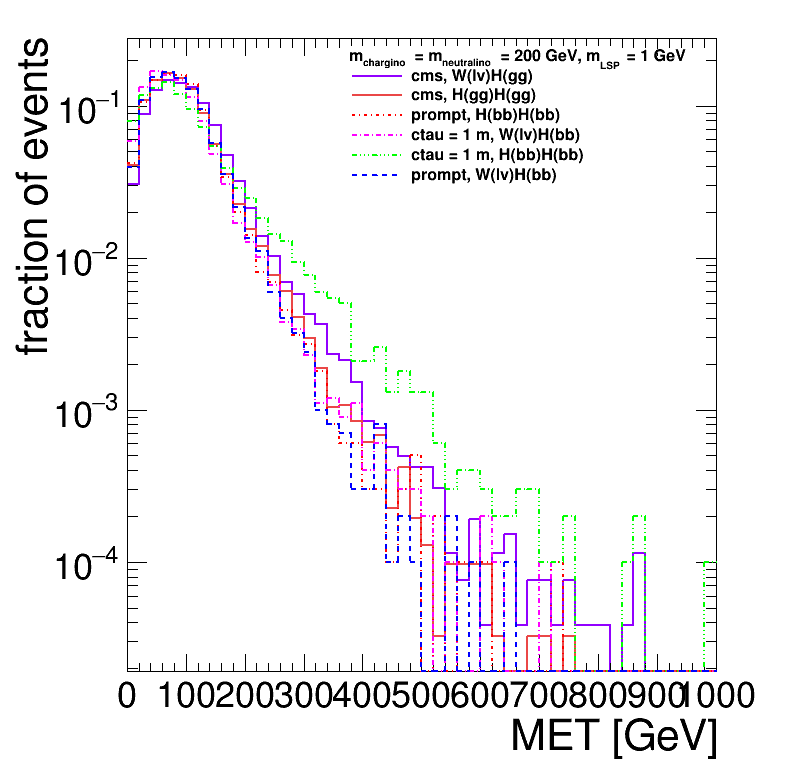

In [4]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0

# h = []
h = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    if 'evt' in k:
        met = v['MissingET.MET'].array()
        
        print(type(met))

#         met_all = met.flatten()


        h[k] = create_TH1D( met, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(i+2)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1
    
    elif 'TChi' in k:
        met = v['MET'].array()
#         met_all =  met.flatten()
        
        h[k] = create_TH1D( met, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(1)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'met.png')

pl1000_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7f43a1ef22b0>
<class 'awkward.array.jagged.JaggedArray'>
pl1000_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7f43cffbbf60>
2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f4429939128>
2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f43d00c7780>
prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7f43a1d31630>
prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7f43a1b27240>
<class 'awkward.array.jagged.JaggedArray'>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190905/met_hh.png has been created


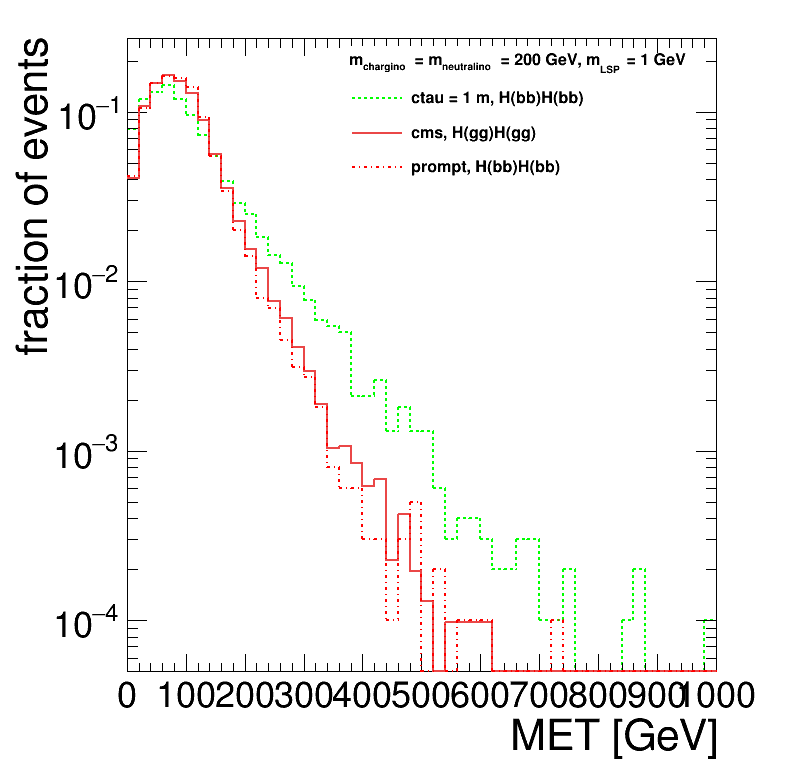

In [113]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0

# h = []
h = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    if 'hbb-hbb' in k:
        met = v['MissingET.MET'].array()
        
        print(type(met))

#         met_all = met.flatten()


        h[k] = create_TH1D( met, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(i+2)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1
    
    elif 'TChiHH' in k:
        met = v['MET'].array()
#         met_all =  met.flatten()
        
        h[k] = create_TH1D( met, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(1)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'met_hh.png')

pl1000_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7f43a1ef22b0>
pl1000_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7f43cffbbf60>
<class 'awkward.array.jagged.JaggedArray'>
2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f4429939128>
2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f43d00c7780>
prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7f43a1d31630>
<class 'awkward.array.jagged.JaggedArray'>
prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7f43a1b27240>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190905/met_wh.png has been created


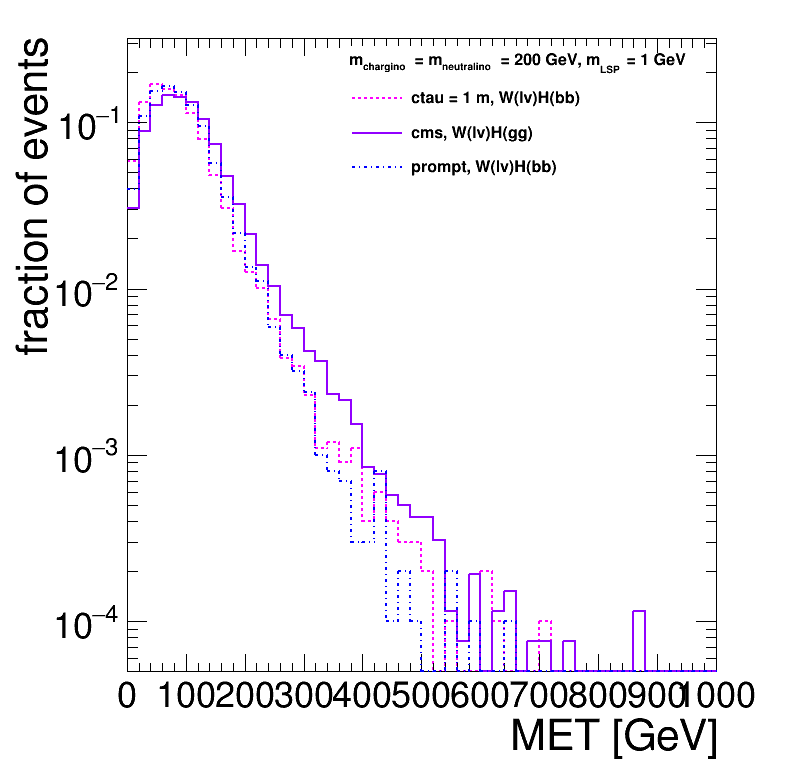

In [114]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0

# h = []
h = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    if 'wlv-hbb' in k:
        met = v['MissingET.MET'].array()
        
        print(type(met))

#         met_all = met.flatten()


        h[k] = create_TH1D( met, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(i+2)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1
    
    elif 'TChiWH' in k:
#         met = v['MET'].array()
        met = v['MET'].array()
#         met_all =  met.flatten()
        
        h[k] = create_TH1D( met, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(1)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'met_wh.png')

2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7fbe22199978>
2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7fbe20161cf8>
prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7fbe1c343fd0>
<class 'awkward.array.jagged.JaggedArray'>
pl1000_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7fbdec911be0>
<class 'awkward.array.jagged.JaggedArray'>
pl1000_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7fbdc2b774a8>
<class 'awkward.array.jagged.JaggedArray'>
prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7fbd94ae5128>
<class 'awkward.array.jagged.JaggedArray'>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190905/met.png has been created


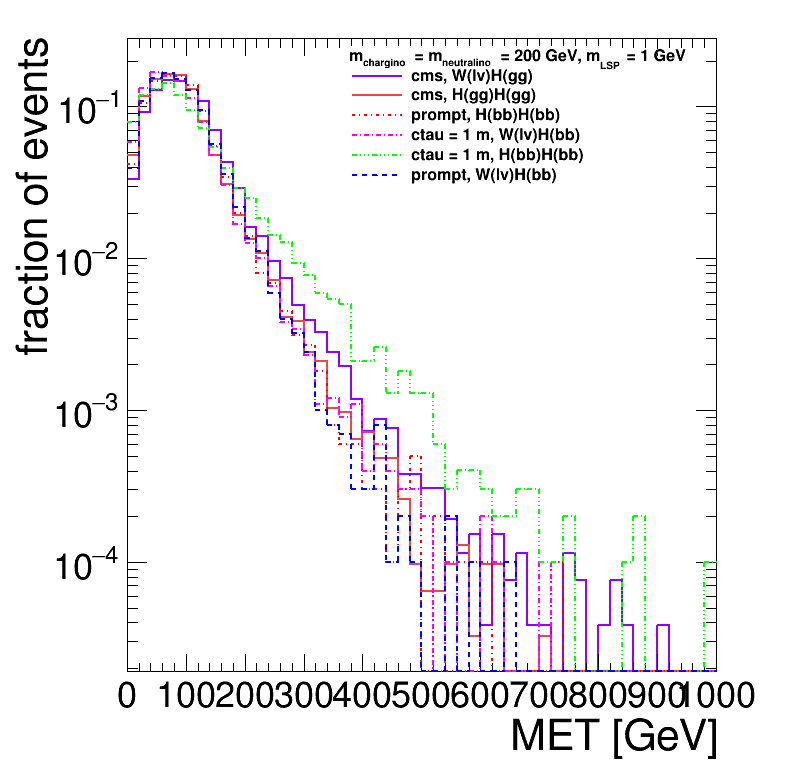

In [5]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0

# h = []
h = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    if 'evt' in k:
        met = v['MissingET.MET'].array()
        
        print(type(met))

#         met_all = met.flatten()


        h[k] = create_TH1D( met, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(i+2)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1
    
    elif 'TChi' in k:
        met = v['genMetPt'].array()
#         met = v['MET'].array()
#         met_all =  met.flatten()
        
        h[k] = create_TH1D( met, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(1)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
# c.SaveAs(out_dir+'met.png')

# Higgs Pt

2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7fbe22199978>
2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7fbe20161cf8>
prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7fbe1c343fd0>
<class 'awkward.array.jagged.JaggedArray'>
pl1000_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7fbdec911be0>
<class 'awkward.array.jagged.JaggedArray'>
pl1000_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7fbdc2b774a8>
<class 'awkward.array.jagged.JaggedArray'>
prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7fbd94ae5128>
<class 'awkward.array.jagged.JaggedArray'>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190905/met.png has been created


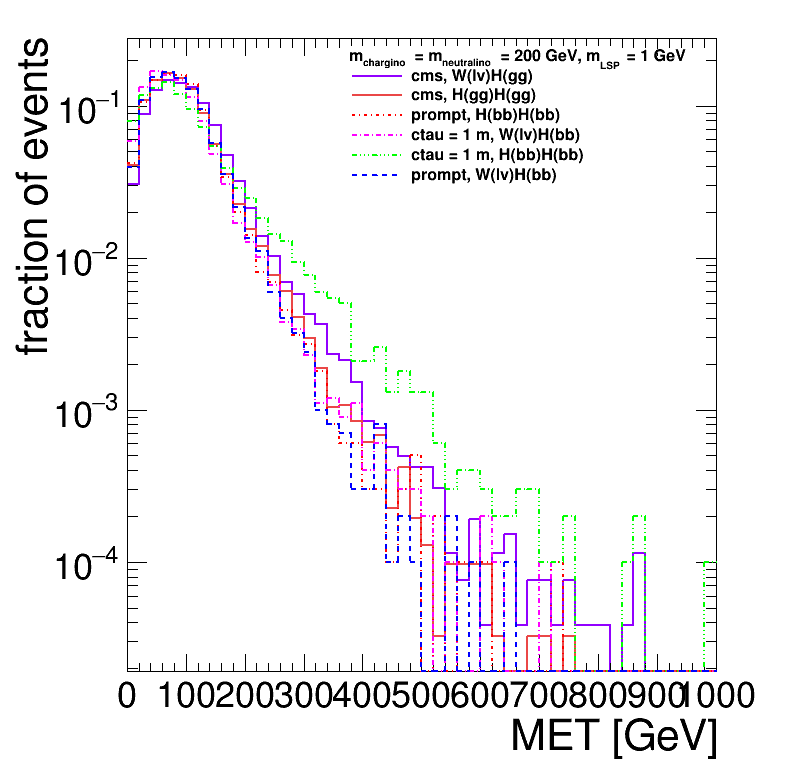

In [4]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0

# h = []
h = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
    if 'evt' in k:
        met = v['MissingET.MET'].array()
        
        print(type(met))

#         met_all = met.flatten()


        h[k] = create_TH1D( met, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(i+2)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1
    
    elif 'TChi' in k:
        met = v['HPt'].array()
#         met_all =  met.flatten()
        
        h[k] = create_TH1D( met, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(1)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
# c.SaveAs(out_dir+'HPt.png')

In [6]:
def find_index(array1, array2):
#     print('abcde')
    out_list = []
    for i, (x,y) in enumerate(zip(array1,array2)):
#         print(i,x,y)
        out = []
        for j, (x1,y1) in enumerate(zip(x,y)):
#             print(j,x1,y1)
#             if i==0 and j==0 :
#                 print('find :',x[y1])
            out.append(x[y1])
        out = np.array(out)
        out_list.append(out)
#         if i>2:
#             break
    return out_list

abcde


0

2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f25c7689588>
pl1000_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7f25c28358d0>
prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7f2598ba6b38>
<class 'awkward.array.jagged.JaggedArray'>
<class 'numpy.ndarray'>
False
no
[91.77602]
prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7f256e45d518>
<class 'awkward.array.jagged.JaggedArray'>
<class 'numpy.ndarray'>
False
no
[126.08607, 46.009888]
pl1000_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7f253e94d390>
2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f25108c0198>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


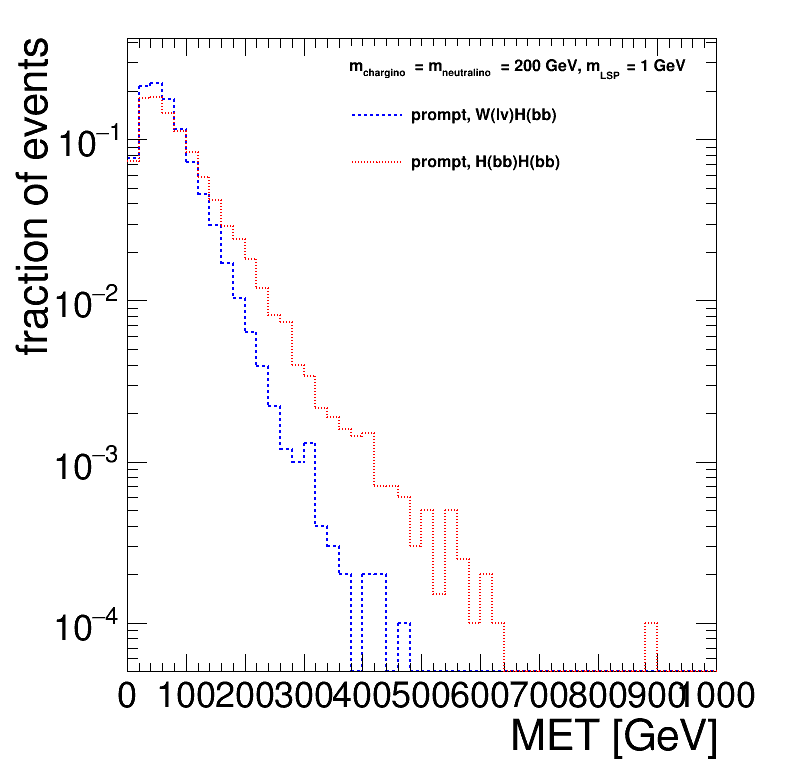

In [13]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0

# h = []
h = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
#     if 'evt' in k:
    if 'prompt' in k:
        pid = v['Particle.PID'].array()
        status = v['Particle.Status'].array()
        pt = v['Particle.PT'].array()
        m1 = v['Particle.M1'].array()
        d2 = v['Particle.D2'].array()
    #     bro_pt = v['Particle.PT[Particle.D2[Particle.M1]]'].array()
    
#         print(pid[0][0],pt[0][0])
        #find pt of d2
#         pt_d2 = find_index(pt, d2)
        #find d2 of m1
        d2_m1 = find_index(d2, m1)
        #fine pt of d2 from m1
        pt_d2_m1 = find_index(pt, d2_m1)
        
        #check
#         print(pt_d2[0][0])
#         print('d2_m1', d2_m1[0][0])
#         print('m1', m1[0][0])
#         print('d2', d2[0][5])
#         print('pt', pt[0][1])
#         print(pt_d2_m1[0][0])

        basic_str = np.logical_and(pid==5, status==23)
#         print(basic_str[0])
        print(type(basic_str))
        print(type(basic_str[0]))
        print(basic_str[0][0])
        
        if basic_str[0][0]:
            print('yes')
        else:
            print('no')
    
        #get b pt of d2 from m1
        out_b_pt = []
        out_b_pt_flat = []
        for index1, value1 in enumerate(pt_d2_m1):
#             print(index1)
            out_b_pt_1 = []
            for index2, value2 in enumerate(value1):
#                 print(index2)
            
                if basic_str[index1][index2]:
                    out_b_pt_1.append(value2)
                    out_b_pt_flat.append(value2)         
            if index1==0:
                print(out_b_pt_1)
#                 break
            out_b_pt_1 = np.array(out_b_pt_1)
            out_b_pt.append(out_b_pt_1)
        

#         b_pt_d2_m1_all = out_b_pt.flatten()


        h[k] = create_TH1D( out_b_pt_flat, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(i+2)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1
    
#     elif 'TChi' in k:
#         met = v['MET'].array()
# #         met_all =  met.flatten()
        
#         h[k] = create_TH1D( met, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
#         h[k].SetLineStyle(1)
#         h[k].SetLineColor(cols[k])
#         h[k].SetMarkerColor(cols[k])

#         h[k].DrawNormalized('same')

#         leg.AddEntry(h[k], texs[k])
 
#         i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
# c.SaveAs(out_dir+'met.png')

2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f25c7689588>
pl1000_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7f25c28358d0>
prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7f2598ba6b38>
<class 'awkward.array.jagged.JaggedArray'>
<class 'numpy.ndarray'>
False
no
[91.77602]
prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root 91.77602
prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7f256e45d518>
<class 'awkward.array.jagged.JaggedArray'>
<class 'numpy.ndarray'>
False
no
[126.08607, 46.009888]
prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root 126.08607
pl1000_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7f253e94d390>
2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f25108c0198>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


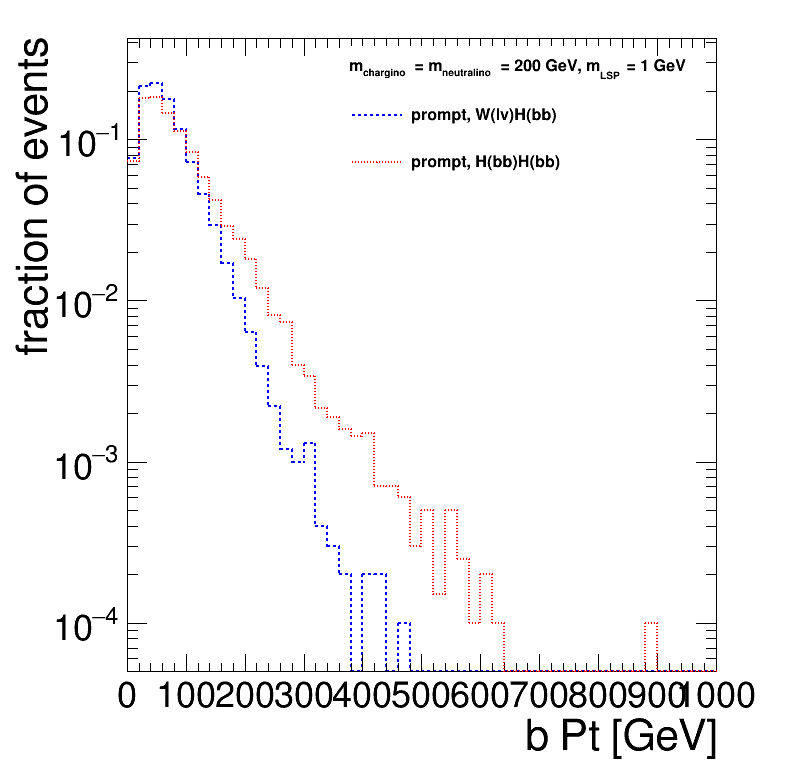

In [20]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0

# h = []
h = {}
out_b_save = {}

# print('i,j,n,s,m,a')

for k,v in tree.items(): 
    print(k,v)
    
#     if 'evt' in k:
    if 'prompt' in k:
        pid = v['Particle.PID'].array()
        status = v['Particle.Status'].array()
        pt = v['Particle.PT'].array()
        m1 = v['Particle.M1'].array()
        d2 = v['Particle.D2'].array()
    #     bro_pt = v['Particle.PT[Particle.D2[Particle.M1]]'].array()
    
#         print(pid[0][0],pt[0][0])
        #find pt of d2
#         pt_d2 = find_index(pt, d2)
        #find d2 of m1
        d2_m1 = find_index(d2, m1)
        #fine pt of d2 from m1
        pt_d2_m1 = find_index(pt, d2_m1)
        
        #check
#         print(pt_d2[0][0])
#         print('d2_m1', d2_m1[0][0])
#         print('m1', m1[0][0])
#         print('d2', d2[0][5])
#         print('pt', pt[0][1])
#         print(pt_d2_m1[0][0])

        basic_str = np.logical_and(pid==5, status==23)
#         print(basic_str[0])
        print(type(basic_str))
        print(type(basic_str[0]))
        print(basic_str[0][0])
        
        if basic_str[0][0]:
            print('yes')
        else:
            print('no')
    
        #get b pt of d2 from m1
        out_b_pt = []
        out_b_pt_flat = []
        for index1, value1 in enumerate(pt_d2_m1):
#             print(index1)
            out_b_pt_1 = []
            for index2, value2 in enumerate(value1):
#                 print(index2)
            
                if basic_str[index1][index2]:
                    out_b_pt_1.append(value2)
                    out_b_pt_flat.append(value2)         
            if index1==0:
                print(out_b_pt_1)
#                 break
            out_b_pt_1 = np.array(out_b_pt_1)
            out_b_pt.append(out_b_pt_1)
        

#         b_pt_d2_m1_all = out_b_pt.flatten()

        out_b_save[k] = out_b_pt_flat
        print(k, out_b_save[k][0])


        h[k] = create_TH1D( out_b_pt_flat, axis_title=['b Pt [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(i+2)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1
    
#     elif 'TChi' in k:
#         met = v['MET'].array()
# #         met_all =  met.flatten()
        
#         h[k] = create_TH1D( met, axis_title=['MET [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
#         h[k].SetLineStyle(1)
#         h[k].SetLineColor(cols[k])
#         h[k].SetMarkerColor(cols[k])

#         h[k].DrawNormalized('same')

#         leg.AddEntry(h[k], texs[k])
 
#         i += 1

leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
# c.SaveAs(out_dir+'b_d2_pt.png')

2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f25c7689588>
pl1000_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7f25c28358d0>
91.77602
91.77602
prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7f2598ba6b38>
91.77602
91.77602
prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7f256e45d518>
126.08607
126.08607
pl1000_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7f253e94d390>
126.08607
126.08607
2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f25108c0198>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190905/b_d2_pt_all.png has been created


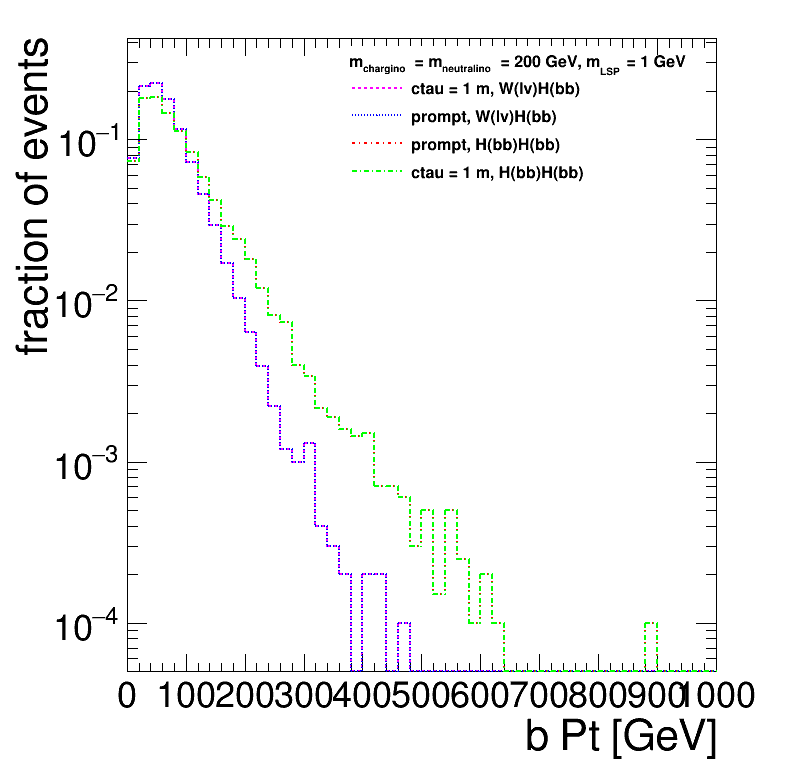

In [25]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0

 
h = {}
# out_b_save = {}


for k,v in tree.items(): 
    print(k,v)
    
#     if 'prompt' in k:
#         print('prompt')

    if 'prompt' in k:
        print(out_b_save[k][0])
    elif 'n3n2' in k:
        out_b_save[k] = out_b_save['prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root']
        print(out_b_save[k][0])        
    elif 'x1n2' in k:
        out_b_save[k] = out_b_save['prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root']
        print(out_b_save[k][0])
        
    if 'evt' in k:
        
        print(out_b_save[k][0])
        b_pt_all = out_b_save[k]


        h[k] = create_TH1D( b_pt_all, axis_title=['b Pt [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(i+2)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1 
    
leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'b_d2_pt_all.png')       
    


2016-SMS-TChiWH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f25c7689588>
pl1000_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7f25c28358d0>
91.77602
91.77602
prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root <TTree b'Delphes' at 0x7f2598ba6b38>
91.77602
91.77602
prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7f256e45d518>
126.08607
126.08607
pl1000_n3n2-n1-hbb-hbb-0827-m200-evt10000.root <TTree b'Delphes' at 0x7f253e94d390>
126.08607
126.08607
2016-SMS-TChiHH_HToGG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_200_1pb_weighted.root <TTree b'HggRazorLeptons' at 0x7f25108c0198>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /nfshome/jmao/cms-llp/plots/20190905/h_pt_all.png has been created


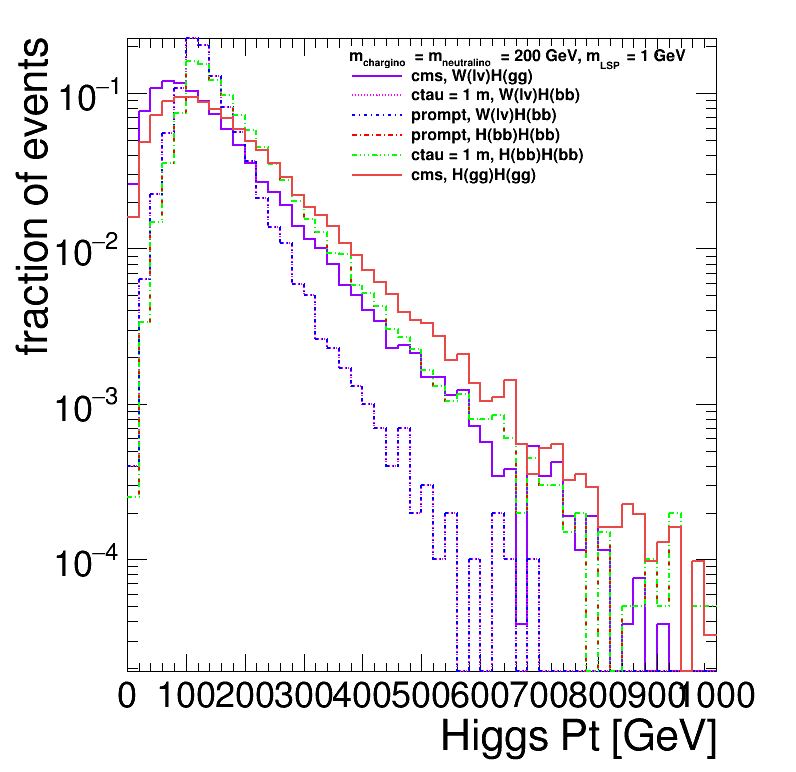

In [29]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.43,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
gr_1j = {}
gr_2j = {}

i = 0

 
h = {}
# out_b_save = {}


for k,v in tree.items(): 
    print(k,v)
    
    if 'prompt' in k:
        print(out_b_save[k][0])
    elif 'n3n2' in k:
        out_b_save[k] = out_b_save['prompt_n3n2-n1-hbb-hbb-0827-m200-evt10000.root']
        print(out_b_save[k][0])        
    elif 'x1n2' in k:
        out_b_save[k] = out_b_save['prompt_x1n2-n1-wlv-hbb-0905-m200-1-evt10000.root']
        print(out_b_save[k][0])
        
    if 'evt' in k:
        
        print(out_b_save[k][0])
        b2_pt_all = out_b_save[k]

    
        pid = v['Particle.PID'].array()
        status = v['Particle.Status'].array()
        pt = v['Particle.PT'].array()

        basic_str = np.logical_and(pid==5, status==23)

        b_pt = pt[basic_str]

        b1_pt_all = b_pt.flatten()
        
        h_pt_all = [x+y for x,y in zip(b1_pt_all,b2_pt_all)]
#         print(b1_pt_all[0], b2_pt_all[0], h_pt_all[0])


        h[k] = create_TH1D( h_pt_all, axis_title=['Higgs Pt [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(i+2)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1 
    
    elif 'TChi' in k:
        hpt = v['HPt'].array()
#         met_all =  met.flatten()
        
        h[k] = create_TH1D( hpt, axis_title=['Higgs Pt [GeV]', 'fraction of events'], name="", binning=[50,-0,1000])
        h[k].SetLineStyle(1)
        h[k].SetLineColor(cols[k])
        h[k].SetMarkerColor(cols[k])

        h[k].DrawNormalized('same')

        leg.AddEntry(h[k], texs[k])
 
        i += 1
    
leg.SetHeader('m_{chargino} = m_{neutralino} = 200 GeV, m_{LSP} = 1 GeV')
leg.Draw()

c.SetLogy()
c.SetRightMargin(0.1)
c.Update()
c.Draw()
c.SaveAs(out_dir+'h_pt_all.png')       
    
